In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import ttest_1samp

#plotting stuff
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Myriad Pro"

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import Author, compare_nets

%matplotlib inline

## Load data

In [2]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

In [3]:
# functions
# group meeting function
def group_meet(n, auths, idx, meets_per_year):
    curr_meets = {}
    for n in range(meets_per_year):
        for j in range(int(n)):        
            # pick author for meeting
            k = np.random.choice(idx)

            # check if at least one will meet
            [m12,m21] = compare_nets(auths[j], auths[k], meet_method)
            a1_size = auths[j].network.vcount()
            a2_size = auths[k].network.vcount()
            if any([m12,m21]):
                # if yes, update the network
                if m12:
                    bib = auths[k].get_cites(bib_length)
                    auths[j].update_network(bib, auths[k].network, learn_thr)
                    # forget
                    auths[j].forget(n=auths[j].network.vcount()-a1_size)
                if m21:
                    bib = auths[j].get_cites(bib_length)
                    auths[k].update_network(bib, auths[j].network, learn_thr)
                    # forget
                    auths[k].forget(n=auths[k].network.vcount()-a2_size)
            # log information
            # update meets
            if n == 0:
                curr_meets[j] = {'gender1': auths[j].gender, 'gender2':auths[k].gender, 'meet12':m12, 'meet21':m21}
    
    curr_auths = [auths[x] for x in idx]
    w_index = [a.gender == 'W' for a in curr_auths]
    m_index = [not(x) for x in w_index]
    # get network size
    net_size = (np.mean([len(a.memory) for a in curr_auths]),np.std([len(a.memory) for a in curr_auths]))
    # update cites
    bibs = [a.get_cites(bib_length) for a in curr_auths]
    bibs_w = [b for i,b in enumerate(bibs) if w_index[i]]
    bibs_m = [b for i,b in enumerate(bibs) if m_index[i]]
    
    return curr_meets, net_size, bibs, bibs_w, bibs_m


## Parameter distributions and constants

#### Thresholds and constants

In [4]:
nAuth = 400
nAuthSt = 200 # how many authors we start with
nYears = 23
meets_per_year = 10
learn_thr = .1
c = 3
diam = 3
net_size = 500
bib_length = 70
woman_perc_i = .36
meet_method = 'soc'
woman_perc_f = 0.5 #sum([x['gender'] == 'woman' for x in node_2_gender.values()])/len(node_2_gender)
colors = ['#d97d5b', '#4a3b90', '#5295d0', '#fabc50']

#### Netbias
Men have 8.2 +/- 3% more men in their coauthor networks. MM teams have 4.4% +/- .1 more MM papers, WW team have 0.8% +/- .3 

In [5]:
# parameters (mean, stdev) for each distribution
net_w = (.51,.01)
net_m = (.43,.01)

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


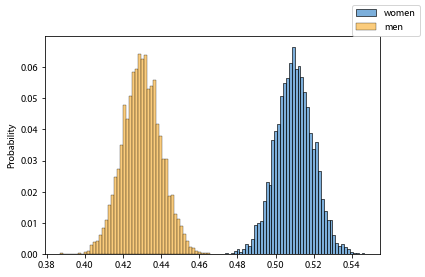

In [6]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=net_w[0],scale=net_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=net_m[0],scale=net_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/alpha.pdf')

#### Walk bias
After regressing out co-auth networks, men cite MM at 5.9+/-.4. WW (w/o co-auth regression) WW at 9.5+/5.5

In [7]:
walk_w = (.60,.1)
walk_m = (.44,.1)

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


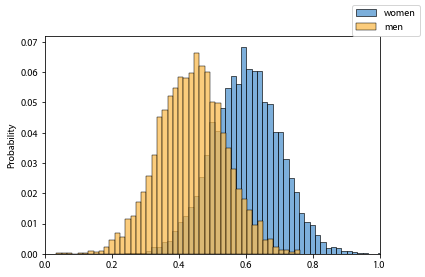

In [8]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[3], stat='probability')
ax.set_xlim(0,1)
f.legend(labels=['women','men'])
plt.savefig('../data/img/beta.pdf')

#### Meet bias
People in the majority are less interdisciplinary

In [9]:
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.05,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


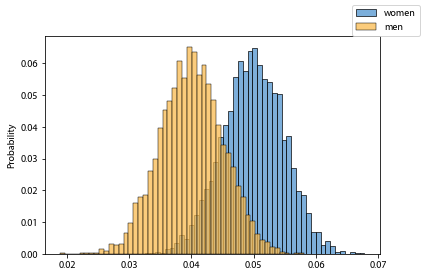

In [10]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/gamma.pdf')

#### Learn bias
Mean taken from Chris's paper. Adam Grant paper about talking over women (20%)

In [11]:
learn_w = (-1,.75)
learn_m = (-1,.75)

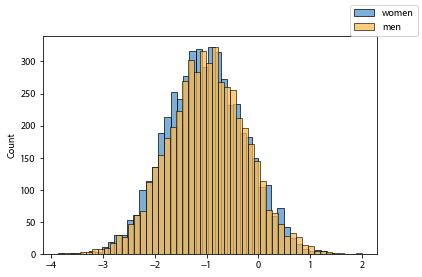

In [12]:
f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.log(np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=5000)), color=colors[2])
sns.histplot(np.log(np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=5000)), color=colors[3])
f.legend(labels=['women','men'])

## Simulations


#### Social

In [13]:
# generate authors
authors = []
for i in range(nAuth+100): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = np.random.normal(loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size,diam,c)
    authors.append(a)


In [14]:
# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


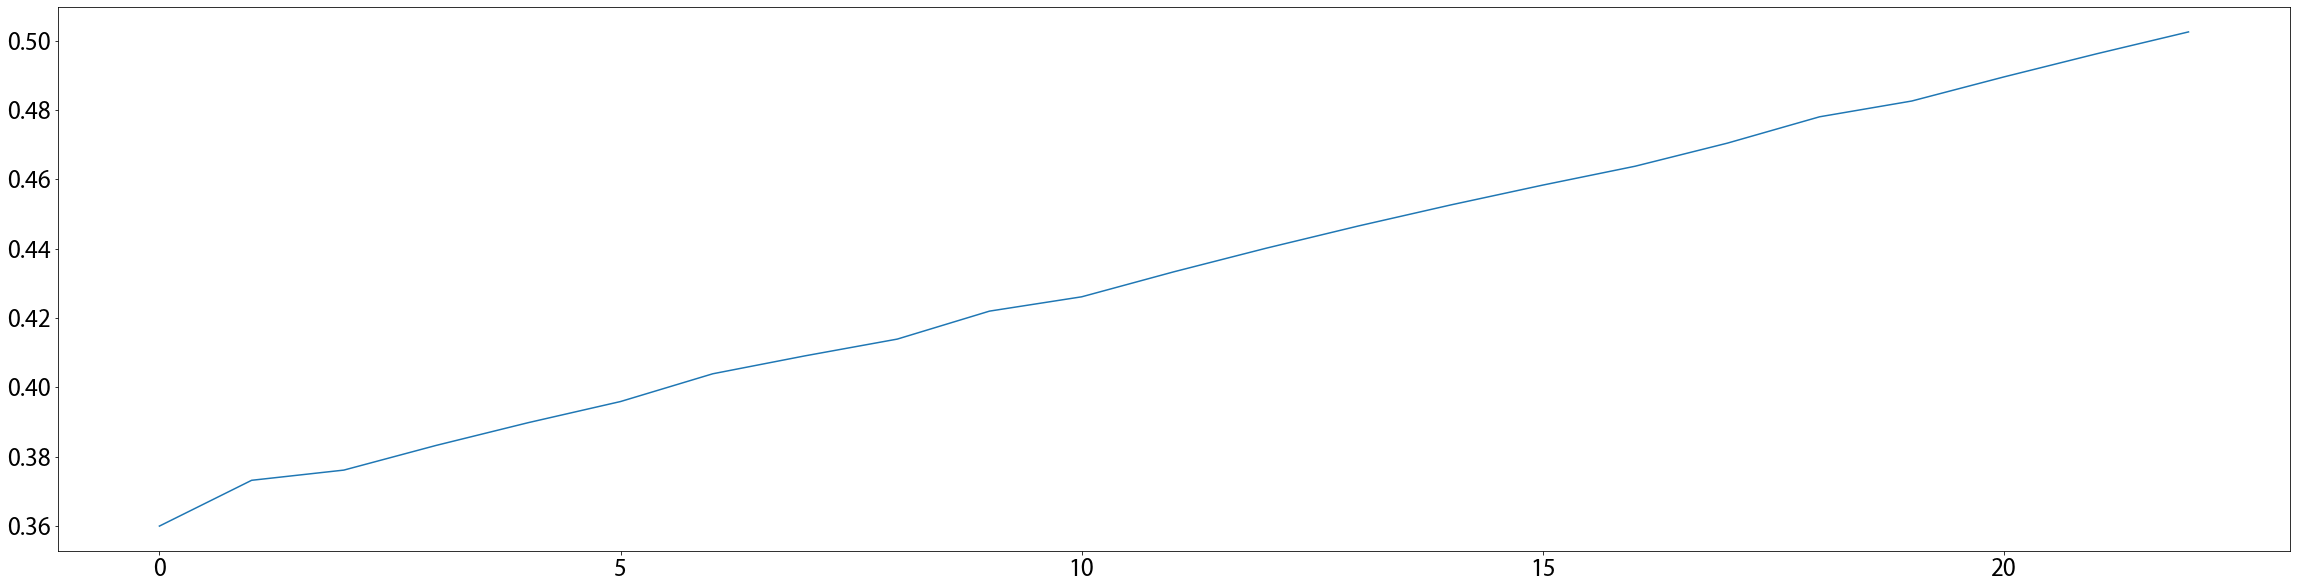

In [15]:
# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])
plt.savefig('../data/img/tv_gender_prop.pdf')

In [16]:
# run simulation
data = []
for i,b in tqdm(enumerate(range(nYears))):
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

23it [00:42,  1.85s/it]


In [17]:
# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms


#### Plots

<AxesSubplot:>

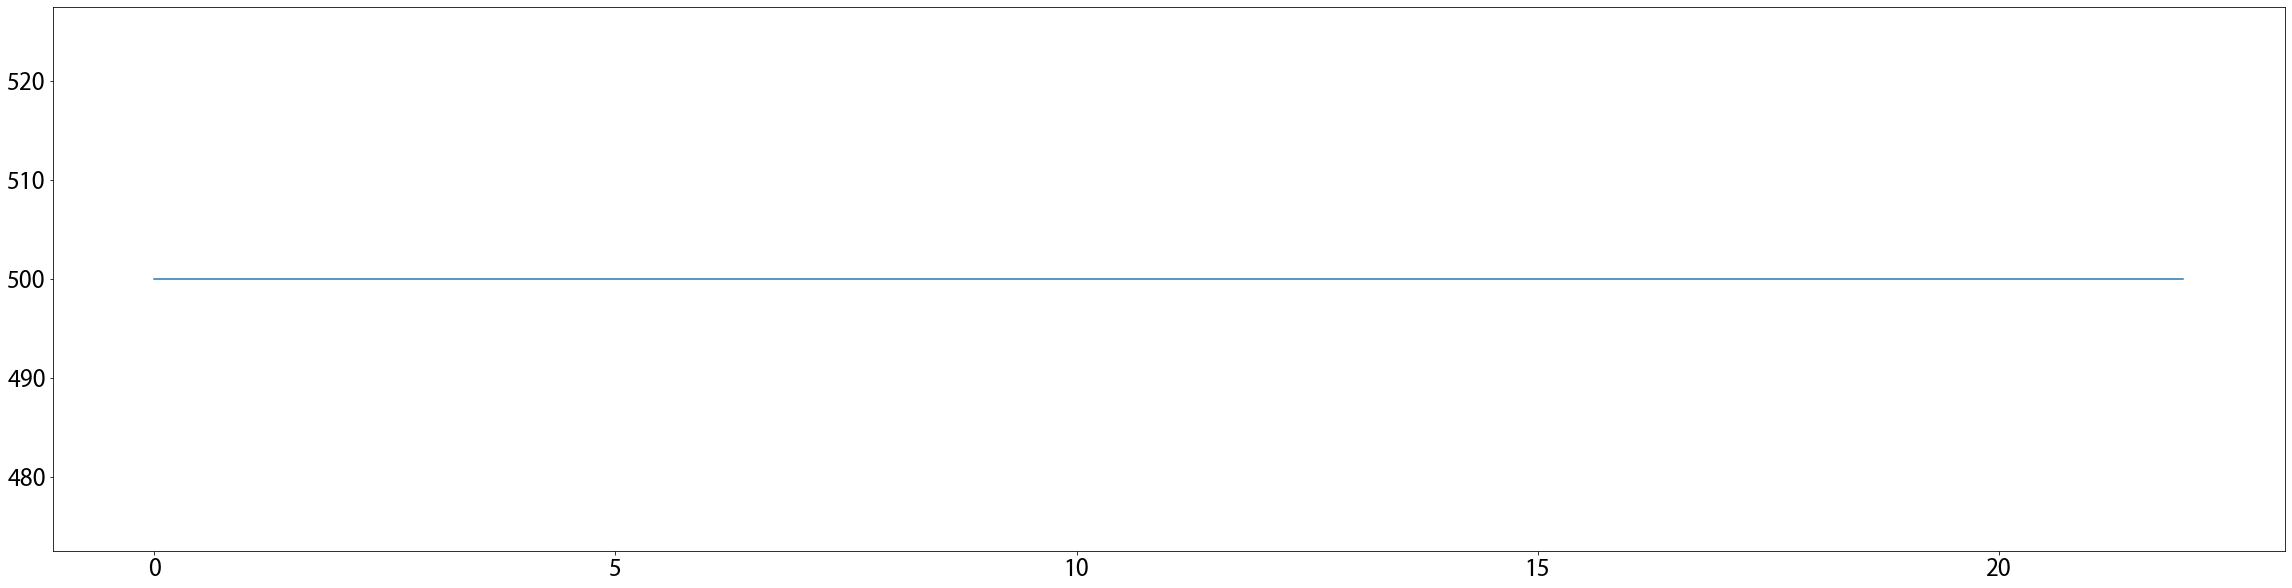

In [18]:
# network size (stopping at 460 for 0.4)
plt.figure(figsize=(40,10))
sns.lineplot(data=[x[0] for x in net_size])

ValueError: min() arg is an empty sequence

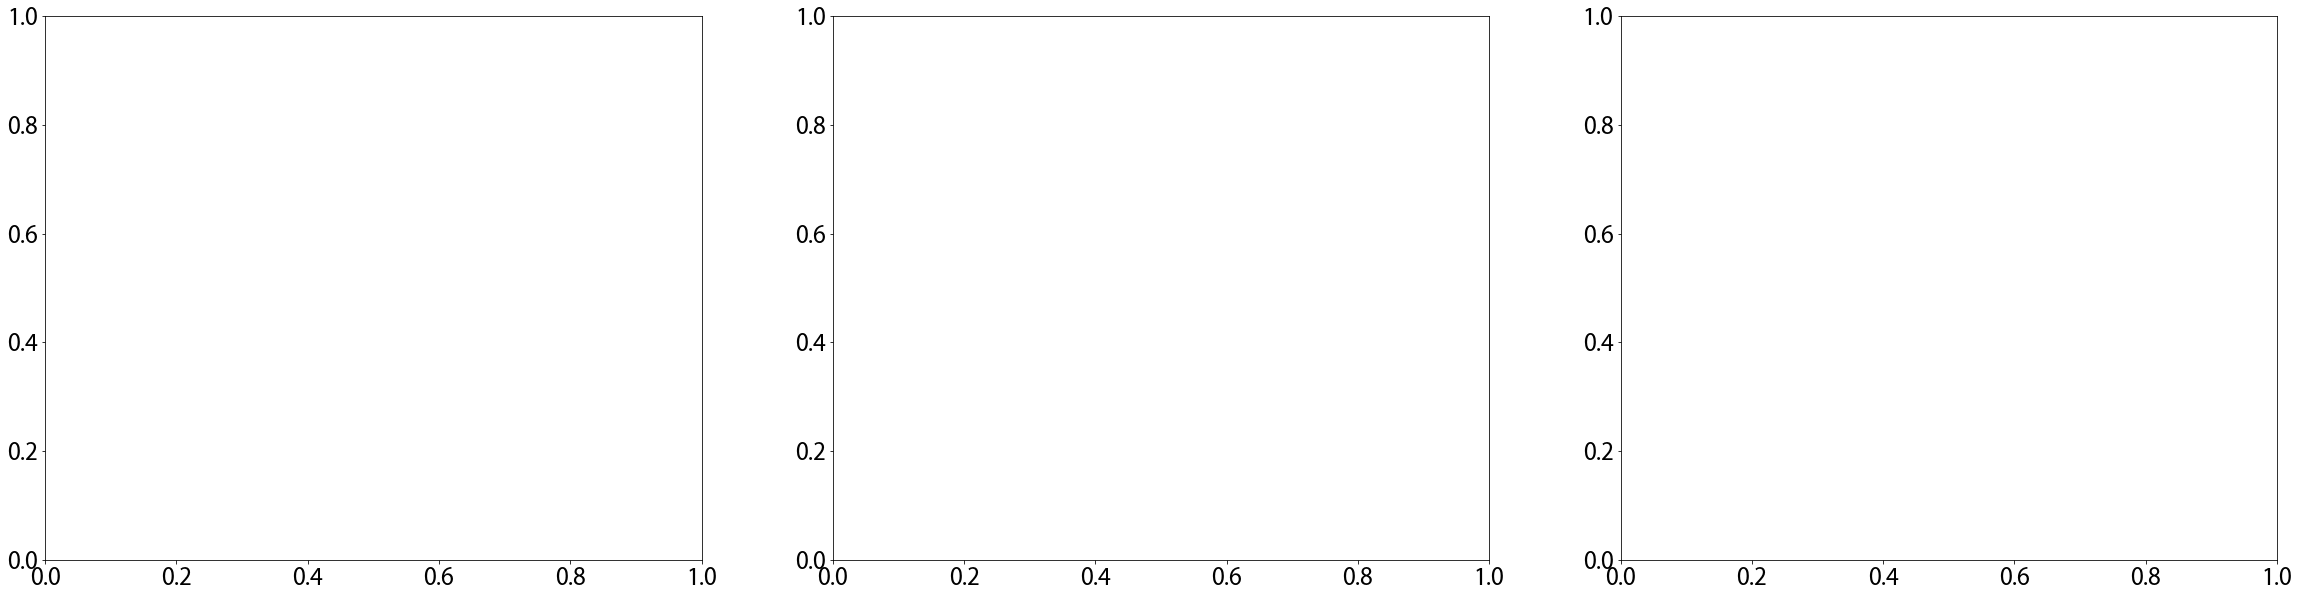

In [19]:
# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

In [ ]:
# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
    

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig('../data/img/static_cites.pdf')



In [ ]:
# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

In [ ]:
cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])


In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w.pdf')

In [ ]:
# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'w'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Womens Citation Practices')
plt.savefig('../data/img/w_cite_w.pdf')

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['citer'] == 'm'], x='time', y='perc', hue='gen',ax=ax, palette=[colors[0],colors[1]])
ax.set_title('Mens Citation Practices')
plt.savefig('../data/img/m_cite_w.pdf')